# Creating base text generation model

Based on amazon food reviews, base model should be able to reproduce (at least, get close to) those reviews with sklearn algorithms.

## Load and analyze data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from tqdm import tqdm
from src.text_preprocessor import TextPreprocessor

tqdm.pandas()

reviews_df = pd.read_csv('../amazon-food-reviews.csv')
reviews_df.columns = [col_name.lower() for col_name in reviews_df.columns]
reviews_df = reviews_df[['text']]
reviews_df = reviews_df.drop_duplicates(subset=['text'])
reviews_df = reviews_df.dropna()
reviews_df.head()

,text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [3]:
text_preprocessor = TextPreprocessor(gentle=True)

reviews_df['text'] = reviews_df['text'].progress_apply(text_preprocessor.process)
reviews_df['wc'] = reviews_df['text'].progress_apply(lambda x: len([word for word in x.split(' ') if word != '']))
reviews_df.describe()

100%|██████████| 393579/393579 [00:03<00:00, 100619.62it/s]


,wc
count,393579.000000
mean,81.830908
std,79.677918
min,0.000000
25%,34.000000
50%,58.000000
75%,100.000000
max,3483.000000


In [4]:
from sklearn.ensemble import IsolationForest

wc_isolation_forest = IsolationForest(contamination=0.2)

wc_vector = reviews_df['wc'].to_numpy().reshape((-1, 1))
print('Fitting...')
wc_isolation_forest.fit(wc_vector)

print('Predicting...')
outlier_mask = wc_isolation_forest.predict(wc_vector)
outlier_idx = outlier_mask == -1

filtered_reviews_df = reviews_df[~outlier_idx]
filtered_reviews_df.describe()

Fitting...
Predicting...


,wc
count,315191.000000
mean,58.239861
std,29.155123
min,21.000000
25%,34.000000
50%,51.000000
75%,78.000000
max,138.000000


<AxesSubplot:>

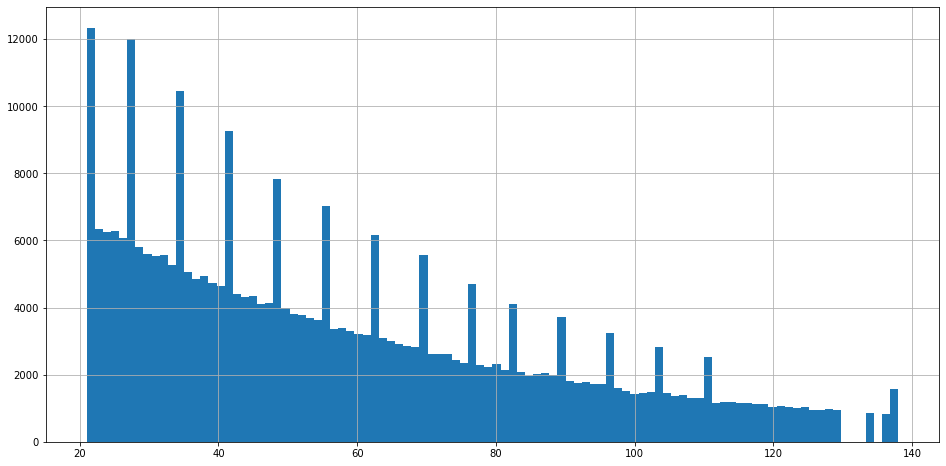

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

filtered_reviews_df['wc'].hist(bins=100, figsize=(16,8))

## Prepare data for training

<AxesSubplot:>

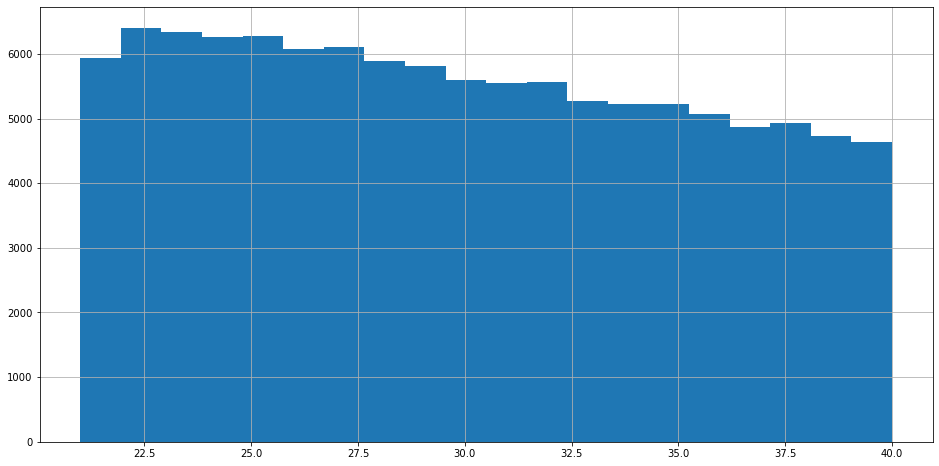

In [9]:
# Debug only!
max_word_count_forced = 41
filtered_reviews_df = filtered_reviews_df[filtered_reviews_df['wc'] < max_word_count_forced]
filtered_reviews_df['wc'].hist(bins=20, figsize=(16,8))

In [10]:
from src.embedding_manager import EmbeddingManager
import numpy as np

em = EmbeddingManager(path='../fasttext.wiki-news-cleaned-290d.vec')

start_token = '<start>'
end_token = '<end>'
pad_token = '<pad>'

# to make preprocessing easier to debug, at first words will be encoded with indicies
input_dict = {word: (i+3) for i, word in enumerate(tqdm(em.embeddings_dict.keys()))}

input_dict[start_token] = 1
input_dict[end_token] = 2
input_dict[pad_token] = 0

reversed_input_dict = {input_dict[key]: key for key in input_dict}

special_vectors = {
    start_token: np.full(em.shape, -2),
    end_token: np.full(em.shape, 2),
    pad_token: np.zeros(em.shape)
}
em.add_special_vectors(special_vectors)

100%|██████████| 611144/611144 [00:54<00:00, 11243.33it/s]


Total embeddings shape: (611143, 290)


100%|██████████| 611143/611143 [00:00<00:00, 1804793.64it/s]


Total embeddings shape: (611146, 290)


In [11]:
filtered_reviews_df['text'] = filtered_reviews_df['text'].apply(lambda row: f'{start_token} {row} {end_token}')

In [12]:
windowed_data = []
for _, row in tqdm(filtered_reviews_df.sample(n=5000).iterrows()):
    words = row['text'].split()
    for i in range(1, len(words)):
        text = ' '.join(words[:i])
        target_word = words[i]
        windowed_data.append({
            'text': text,
            'target_word': target_word
        })
        
windowed_df = pd.DataFrame(windowed_data)
windowed_df.describe()

5000it [00:00, 12591.59it/s]


,text,target_word
count,155636,155636
unique,140579,8122
top,<start>,i
freq,5000,5548


In [13]:
windowed_df['output'] = windowed_df['target_word'].progress_apply(lambda word: input_dict[word] if word in input_dict else -1)
windowed_df = windowed_df[windowed_df['output'] != -1]

windowed_df['seq'] = windowed_df['text'].progress_apply(lambda row: [input_dict[word] for word in row.split() if word in input_dict])
windowed_df['wc'] = windowed_df['text'].progress_apply(lambda x: len([word for word in x.split() if word is not '']))
windowed_df['seq_len'] = windowed_df['seq'].progress_apply(lambda seq: len(seq))

# check how many entries lost more than 20% of words due to vocabulary limitations:
insufficient_vocabulary_df = windowed_df[(windowed_df['seq_len'] * 1.25 < windowed_df['wc'])]
insufficient_vocabulary_df.describe()

100%|██████████| 154925/154925 [00:00<00:00, 855746.50it/s]


,output,wc,seq_len
count,154.000000,154.000000,154.000000
mean,5718.370130,3.857143,2.727273
std,21516.100209,2.399424,1.931076
min,2.000000,2.000000,1.000000
25%,21.250000,3.000000,2.000000
50%,293.000000,4.000000,3.000000
75%,3374.000000,4.000000,3.000000
max,232726.000000,22.000000,17.000000


In [14]:
clean_seq_reviews_df = windowed_df[~windowed_df.index.isin(insufficient_vocabulary_df.index)]
clean_seq_reviews_df.describe()

,output,wc,seq_len
count,154771.000000,154771.000000,154771.000000
mean,4826.574145,16.601230,16.528213
std,23832.513221,9.834444,9.793759
min,2.000000,1.000000,1.000000
25%,17.000000,8.000000,8.000000
50%,111.000000,16.000000,16.000000
75%,1988.000000,24.000000,24.000000
max,611114.000000,41.000000,41.000000


In [15]:
max_seq_len = clean_seq_reviews_df['seq_len'].max()
clean_seq_reviews_df['pad_seq'] = clean_seq_reviews_df['seq'].progress_apply(lambda seq: [0] * (max_seq_len - len(seq)) + seq)

100%|██████████| 154771/154771 [00:00<00:00, 332114.49it/s]


In [16]:
clean_seq_reviews_df.head()

,text,target_word,output,seq,wc,seq_len,pad_seq
0,<start>,none,1882,[1],1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,<start> none,of,5,"[1, 1882]",2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,<start> none of,my,76,"[1, 1882, 5]",3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,<start> none of my,seeds,4755,"[1, 1882, 5, 76]",4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,<start> none of my seeds,sprouted,45161,"[1, 1882, 5, 76, 4755]",5,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Encode data with embeddings

In [17]:
def encode_seq(seq):
    words = [reversed_input_dict[item] for item in seq]
    encoded = [em.get_vector(word) for word in words]
    return encoded

def get_arrayed_data(df_set):
    setX = np.stack(df_set['pad_seq'].progress_apply(encode_seq).values, axis=0)
    setY = np.stack(df_set['output'].progress_apply(lambda x: encode_seq([x])[0]).values, axis=0)        
    return (setX, setY)

In [20]:
trainX, trainY = get_arrayed_data(clean_seq_reviews_df.sample(n=1000))

print(trainX.shape)
print(trainY.shape)

100%|██████████| 1000/1000 [00:00<00:00, 200310.62it/s]

(1000, 41, 290)
(1000, 290)


In [22]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1] * trainX.shape[2]))

In [23]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

regressor = SVR()
mo_regressor = MultiOutputRegressor(estimator=regressor)
mo_regressor.fit(trainX, trainY)

MultiOutputRegressor(estimator=SVR())